# Series temporales simples

In [33]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos 
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

In [34]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


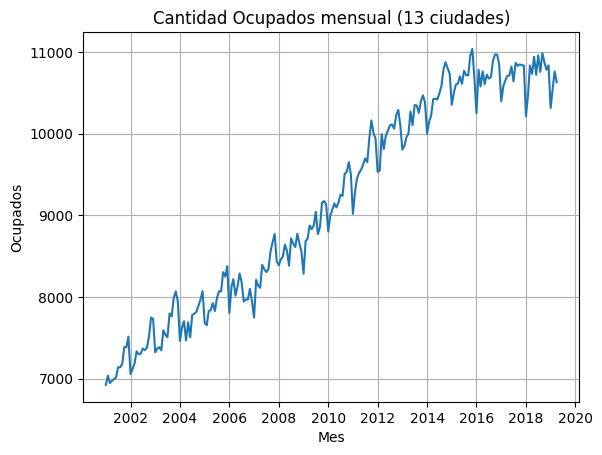

In [35]:
# Graficando los datos
plt.title("Cantidad Ocupados mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

## Evaluation Protocol
### Train-test split

In [36]:
data['year'] = data.index.year
print(data['year'].unique())
print(len(data['year'])) # 220

[2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019]
220


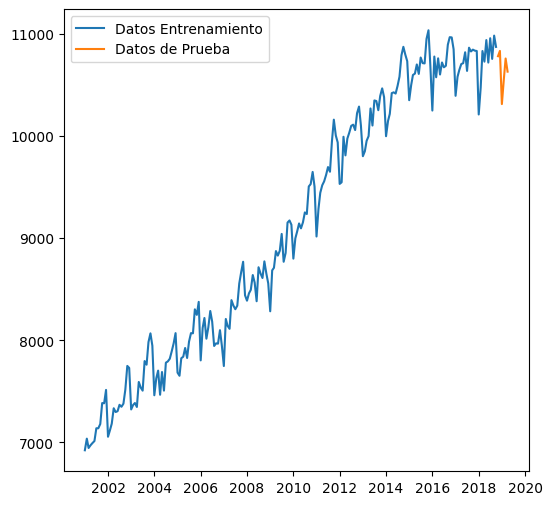

In [61]:
total_data = len(data['year'])
horizon = 6

train_len = total_data - horizon
train_td = data[["Ocupados"]][:train_len]
test_td = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(horizon, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

## Promedio Movil

- **<font color="red">w</font>** represents the window size, which is the number of data points to consider when calculating the moving average.
- **<font color="red">h</font>** represents the horizon, which is the number of future data points to forecast.

In [62]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:] 

In [82]:
movil_avg = [fore_ma(train_td,x,horizon) for x in range(1,25)]

In [83]:
for x in range(len(movil_avg)):
	print(x+1, "------>", np.sqrt(mean_squared_error(test_td,movil_avg[x])))

1 ------> 287.2354279175854
2 ------> 319.1849777906289
3 ------> 298.3770292088787
4 ------> 305.34686253059
5 ------> 291.01606293356485
6 ------> 291.5713004314995
7 ------> 283.4567470273245
8 ------> 279.3491656472429
9 ------> 270.13693523482465
10 ------> 258.0826859664414
11 ------> 245.42326872607504
12 ------> 221.08914545893433
13 ------> 214.50880659854403
14 ------> 213.5825179006286
15 ------> 212.44821683703358
16 ------> 214.88471083985425
17 ------> 218.159032263104
18 ------> 216.56731320777968
19 ------> 216.63618429400097
20 ------> 216.3239820128406
21 ------> 214.08726281143203
22 ------> 212.14619517863974
23 ------> 208.83714957580352
24 ------> 201.65678555054527


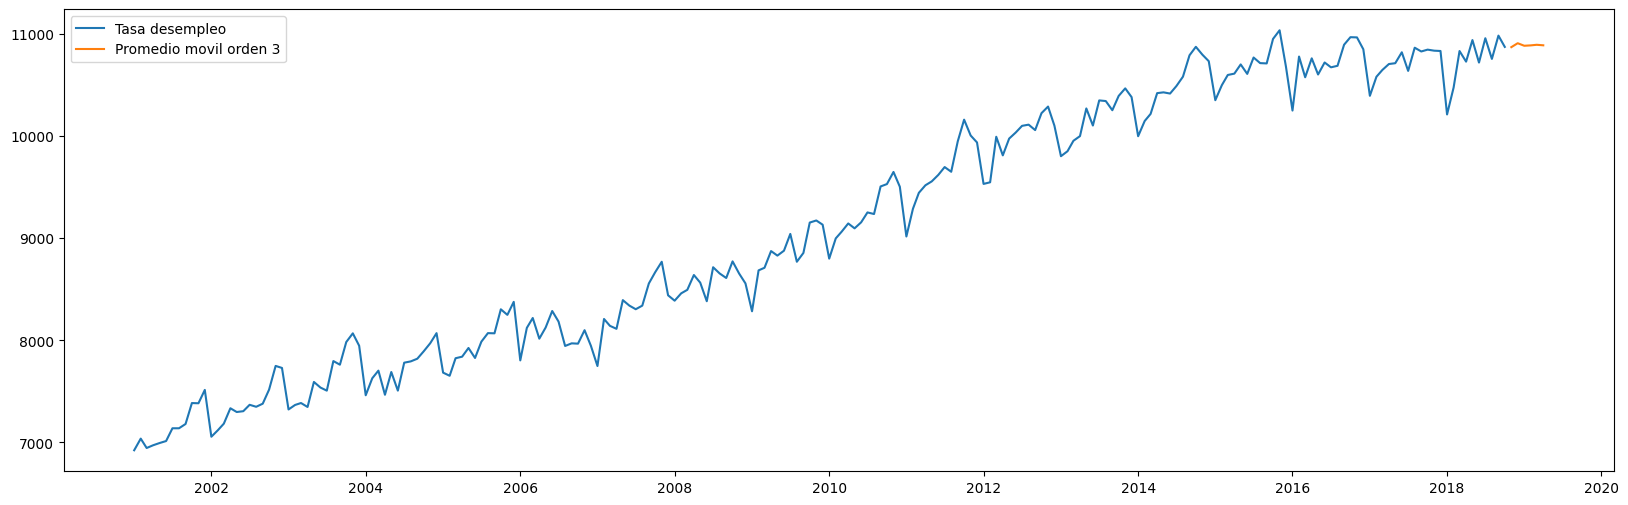

In [65]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Tasa desempleo")
plt.plot(movil_avg[2],label="Promedio movil orden 3")
plt.legend()
plt.show()

- [X] Suavización exponencial simple
- [X] Suavización exponencial lineal Holt
- [X] Suavización exponencial lineal Holt-Winters

In [111]:

# Model
def build_ets_model(train_td, test_td, horizon, error='add', trend=None, seasonal=None):
    # Build model
    ets_model = ETSModel(endog=train_td["Ocupados"], error=error, trend=trend, seasonal=seasonal)
    ets_result = ets_model.fit()

    # Forecast
    point_forecast = ets_result.forecast(horizon)

    # Confidence intervals
    ci = ets_result.get_prediction(start=point_forecast.index[0], end=point_forecast.index[-1])
    conf_forecast = ci.pred_int(alpha=0.05)
    limits = ci.predicted_mean

    # Prepare predictions DataFrame
    preds = pd.concat([limits, conf_forecast], axis=1)
    preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
    print(preds)

    # Plot results
    fig = plt.figure(figsize=(12, 6))
    plt.plot(train_td, label="Datos Entrenamiento")
    plt.plot(preds['Point_forecast'], label="Suavización Exponencial Simple")
    plt.fill_between(preds.index, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
    plt.legend()
    plt.show()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_td, point_forecast))
    print(f"RMSE: {rmse}")

    return {
        "rmse": rmse,
        "alpha": ets_result.alpha,
        "beta": getattr(ets_result, 'beta', None),
        "gamma": getattr(ets_result, 'gamma', None),
        "preds": preds,
	}

## Suavizacion Exponencial Simple

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00361D+00    |proj g|=  8.99900D-01

At iterate    1    f=  6.65961D+00    |proj g|=  2.20979D-01

At iterate    2    f=  6.65209D+00    |proj g|=  1.97071D-01

At iterate    3    f=  6.62025D+00    |proj g|=  2.02028D-02

At iterate    4    f=  6.61991D+00    |proj g|=  6.43663D-04

At iterate    5    f=  6.61991D+00    |proj g|=  1.70532D-05

At iterate    6    f=  6.61991D+00    |proj g|=  1.70532D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


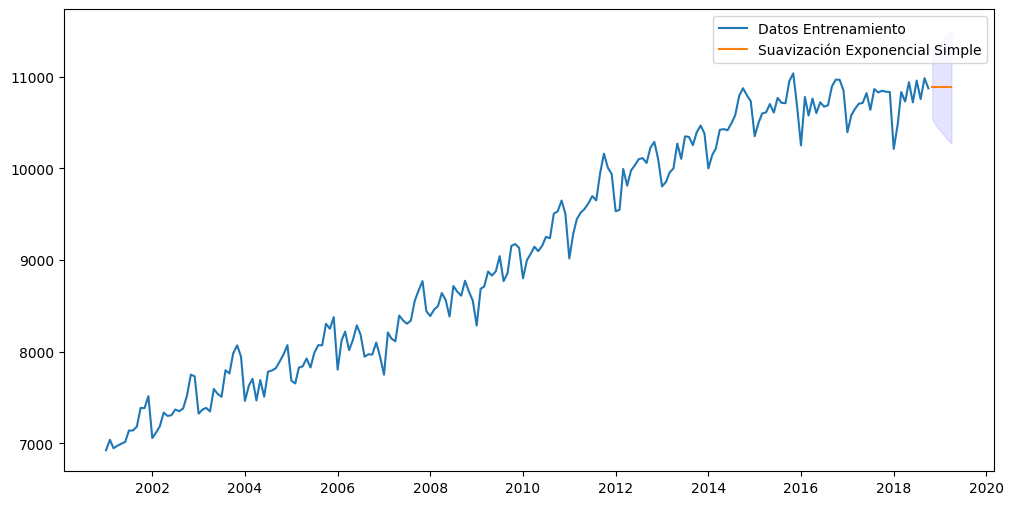

RMSE: 300.42903325132073


In [112]:
suavizacion_exp_simple_add_mse = build_ets_model(train_td, test_td, horizon, error='add')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.01585D+00    |proj g|=  8.99900D-01

At iterate    1    f=  6.65912D+00    |proj g|=  2.39007D-01

At iterate    2    f=  6.65026D+00    |proj g|=  2.12435D-01

At iterate    3    f=  6.61524D+00    |proj g|=  8.77796D-03

At iterate    4    f=  6.61519D+00    |proj g|=  9.00524D-04

At iterate    5    f=  6.61519D+00    |proj g|=  2.86885D-05

At iterate    6    f=  6.61519D+00    |proj g|=  2.85996D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


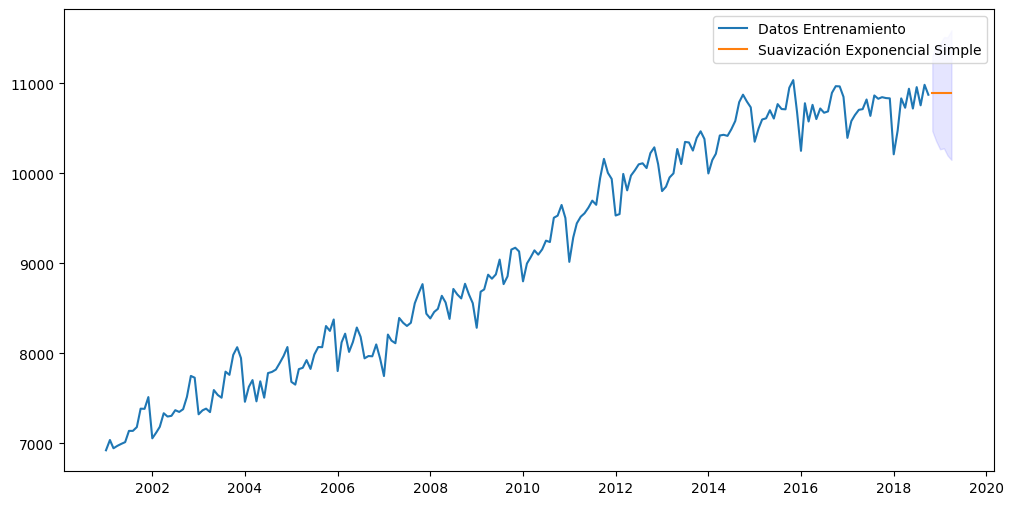

RMSE: 300.4283096351243


In [113]:
suavizacion_exp_simple_mul_mse = build_ets_model(train_td, test_td, horizon, error='mul')

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66820D+00    |proj g|=  3.64846D-01

At iterate    1    f=  6.65919D+00    |proj g|=  1.21201D-01

At iterate    2    f=  6.62778D+00    |proj g|=  5.00397D-02

At iterate    3    f=  6.61711D+00    |proj g|=  2.95754D-02

At iterate    4    f=  6.61425D+00    |proj g|=  1.73269D-02

At iterate    5    f=  6.61386D+00    |proj g|=  8.99467D-03

At iterate    6    f=  6.61379D+00    |proj g|=  1.10106D-02

At iterate    7    f=  6.61377D+00    |proj g|=  3.07745D-03

At iterate    8    f=  6.61377D+00    |proj g|=  7.88347D-04

At iterate    9    f=  6.61377D+00    |proj g|=  4.15579D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

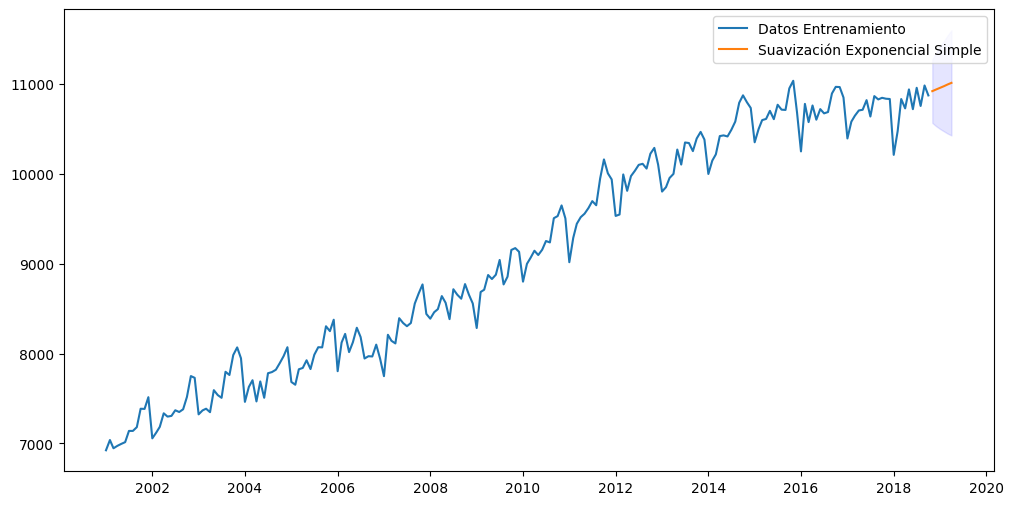

RMSE: 370.1579808023175


In [114]:
suavizacion_exp_lin_holt_add_add_mse = build_ets_model(train_td, test_td, horizon, error='add', trend='add')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.67636D+00    |proj g|=  8.68520D+00

At iterate    1    f=  6.66543D+00    |proj g|=  4.59853D-01

At iterate    2    f=  6.66538D+00    |proj g|=  2.59454D-01

At iterate    3    f=  6.66534D+00    |proj g|=  2.58746D-01

At iterate    4    f=  6.66516D+00    |proj g|=  7.20136D-01

At iterate    5    f=  6.66479D+00    |proj g|=  1.38391D+00

At iterate    6    f=  6.66380D+00    |proj g|=  2.27732D+00

At iterate    7    f=  6.66160D+00    |proj g|=  2.98942D+00

At iterate    8    f=  6.65687D+00    |proj g|=  3.26079D+00

At iterate    9    f=  6.64452D+00    |proj g|=  4.95570D+00

At iterate   10    f=  6.64277D+00    |proj g|=  5.98743D+00

At iterate   11    f=  6.63629D+00    |proj g|=  5.88235D+00

At iterate   12    f=  6.62012D+00    |proj g|=  1.44690D+00

At iterate   13    f=  6.6

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10927.114132  10575.620228  11262.190376
2018-12-01    10948.230514  10538.864308  11343.943766
2019-01-01    10969.387703  10515.192698  11417.937710
2019-02-01    10990.585778  10467.183224  11436.607327
2019-03-01    11011.824817  10483.801227  11510.074652
2019-04-01    11033.104901  10454.371918  11584.766114


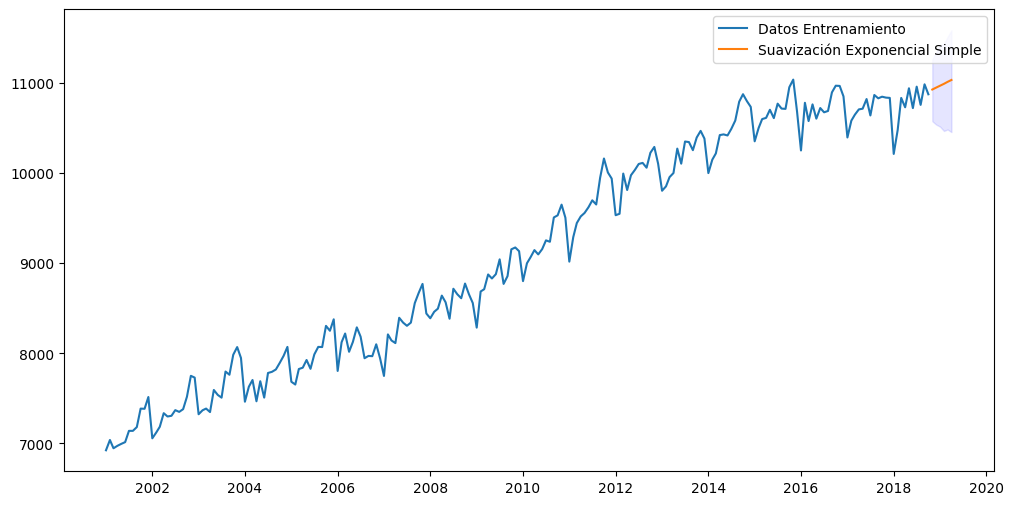

RMSE: 381.54587789028966


In [115]:
suavizacion_exp_lin_holt_add_mul_mse = build_ets_model(train_td, test_td, horizon, error='add', trend='mul')

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.67636D+00    |proj g|=  8.68520D+00

At iterate    1    f=  6.66543D+00    |proj g|=  4.59853D-01

At iterate    2    f=  6.66538D+00    |proj g|=  2.59454D-01

At iterate    3    f=  6.66534D+00    |proj g|=  2.58746D-01

At iterate    4    f=  6.66516D+00    |proj g|=  7.20136D-01

At iterate    5    f=  6.66479D+00    |proj g|=  1.38391D+00

At iterate    6    f=  6.66380D+00    |proj g|=  2.27732D+00

At iterate    7    f=  6.66160D+00    |proj g|=  2.98942D+00

At iterate    8    f=  6.65687D+00    |proj g|=  3.26079D+00

At iterate    9    f=  6.64452D+00    |proj g|=  4.95570D+00

At iterate   10    f=  6.64277D+00    |proj g|=  5.98743D+00

At iterate   11    f=  6.63629D+00    |proj g|=  5.88235D+00

At iterate   12    f=  6.62012D+00    |proj g|=  1.44690D+00

At iterate   13    f=  6.6

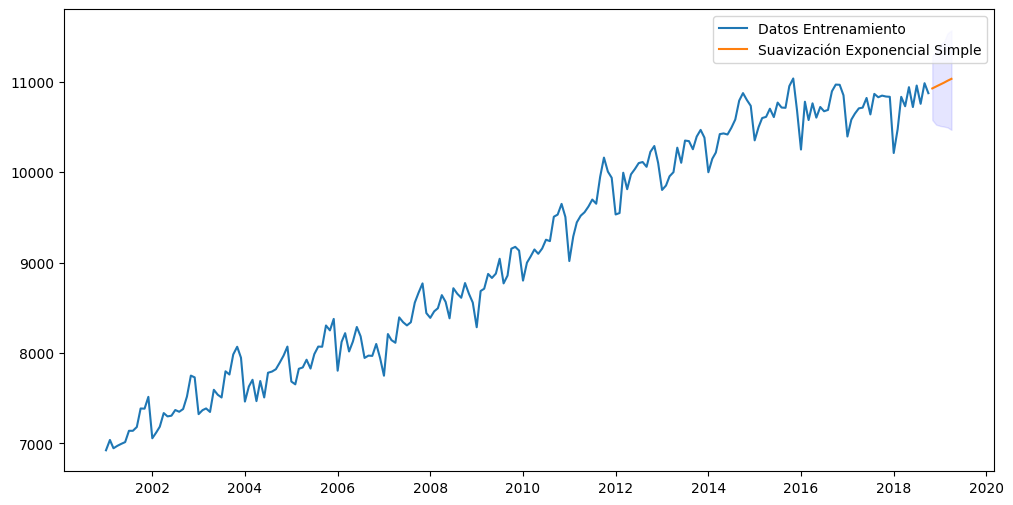

RMSE: 381.54587789028966


In [116]:
suavizacion_exp_lin_holt_mul_mul_mse = build_ets_model(train_td, test_td, horizon, error='add', trend='mul')

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.67290D+00    |proj g|=  4.15763D-01

At iterate    1    f=  6.65596D+00    |proj g|=  1.42095D-01

At iterate    2    f=  6.62218D+00    |proj g|=  5.72791D-02

At iterate    3    f=  6.60947D+00    |proj g|=  4.48643D-02

At iterate    4    f=  6.60520D+00    |proj g|=  2.43944D-02

At iterate    5    f=  6.60468D+00    |proj g|=  1.23758D-02

At iterate    6    f=  6.60454D+00    |proj g|=  1.05938D-02

At iterate    7    f=  6.60454D+00    |proj g|=  7.44240D-03



At iterate    8    f=  6.60454D+00    |proj g|=  5.02887D-04

At iterate    9    f=  6.60454D+00    |proj g|=  5.03064D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     17     11     0     0   5.031D-04   6.605D+00
  F =   6.6045353562618594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
            Point_forecast      lower_95      upper_95
2018-11-01    10922.345055  10502.056524  11345.952819
2018-12-01    10941.164972  10461.635392  11419.219515
2019-01-01    10959.984890  10404.450309  11467.112931
2019-02-01    10978.804808  10381.052099  11557.128527
2019-03-01    10997.6247

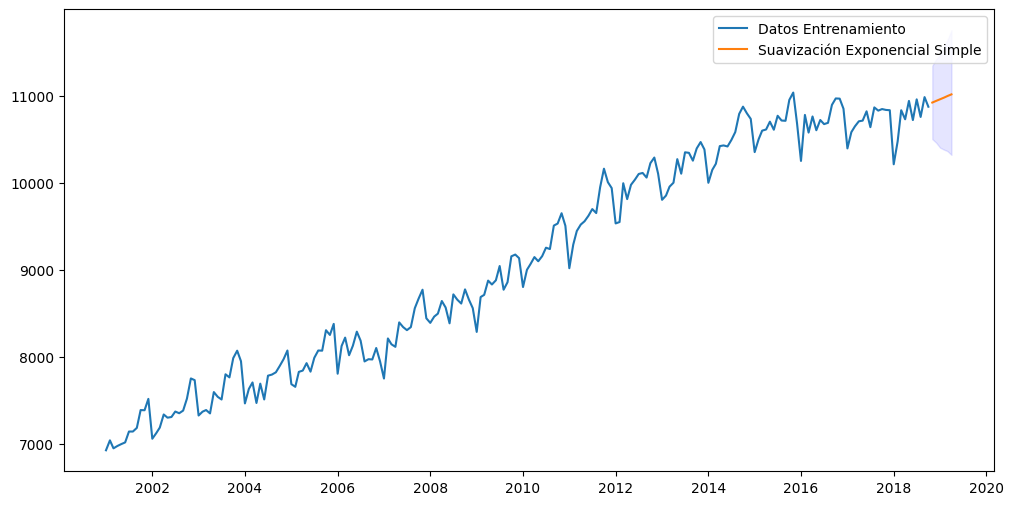

RMSE: 371.54435931077376


In [117]:
suavizacion_exp_lin_holt_mul_add_mse = build_ets_model(train_td, test_td, horizon, error='mul', trend='add')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09576D+00    |proj g|=  9.88789D-01

At iterate    1    f=  6.74975D+00    |proj g|=  9.99800D-01

At iterate    2    f=  6.50222D+00    |proj g|=  1.33209D-01

At iterate    3    f=  6.47924D+00    |proj g|=  1.10766D-01

At iterate    4    f=  6.46870D+00    |proj g|=  9.54304D-02

At iterate    5    f=  6.46694D+00    |proj g|=  7.92133D-02

At iterate    6    f=  6.46002D+00    |proj g|=  9.56205D-02

At iterate    7    f=  6.45785D+00    |proj g|=  3.64552D-02

At iterate    8    f=  6.45653D+00    |proj g|=  3.11578D-02

At iterate    9    f=  6.45596D+00    |proj g|=  2.05009D-02

At iterate   10    f=  6.45564D+00    |proj g|=  1.24158D-02

At iterate   11    f=  6.45542D+00    |proj g|=  2.57518D-03



At iterate   12    f=  6.45540D+00    |proj g|=  9.45466D-04

At iterate   13    f=  6.45540D+00    |proj g|=  3.86091D-04

At iterate   14    f=  6.45540D+00    |proj g|=  3.84670D-04

At iterate   15    f=  6.45539D+00    |proj g|=  5.02887D-04

At iterate   16    f=  6.45539D+00    |proj g|=  1.31823D-03

At iterate   17    f=  6.45538D+00    |proj g|=  2.41673D-03

At iterate   18    f=  6.45535D+00    |proj g|=  4.18670D-03

At iterate   19    f=  6.45529D+00    |proj g|=  6.61364D-03

At iterate   20    f=  6.45515D+00    |proj g|=  9.12950D-03

At iterate   21    f=  6.45490D+00    |proj g|=  9.30269D-03

At iterate   22    f=  6.45467D+00    |proj g|=  6.03082D-03

At iterate   23    f=  6.45458D+00    |proj g|=  3.13332D-03

At iterate   24    f=  6.45456D+00    |proj g|=  2.05373D-03

At iterate   25    f=  6.45455D+00    |proj g|=  4.59721D-04

At iterate   26    f=  6.45455D+00    |proj g|=  2.91944D-04

At iterate   27    f=  6.45455D+00    |proj g|=  3.42393D-04

At itera

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


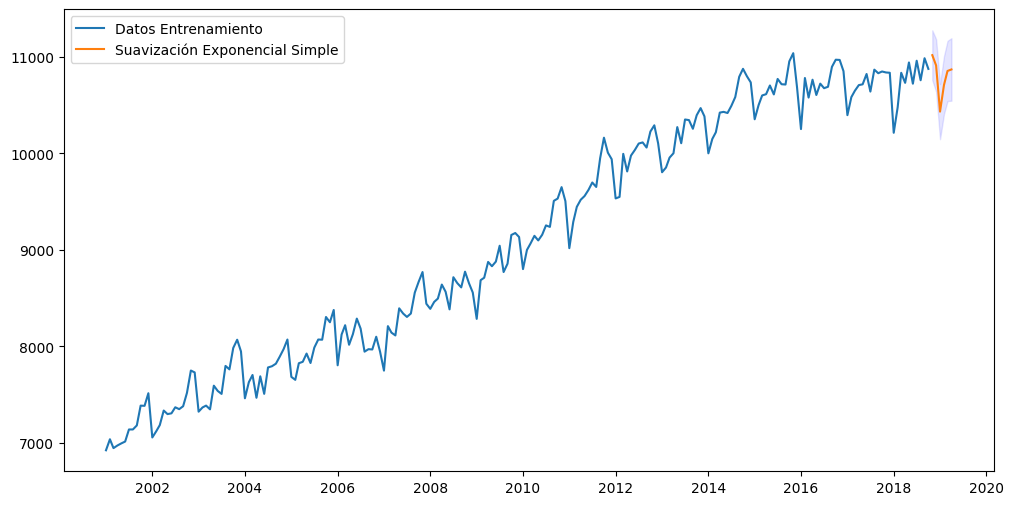

RMSE: 163.6197658382755


In [118]:
suavizacion_exp_lin_holt_winters_add_add_add_mse = build_ets_model(train_td, test_td, horizon, error='add', trend='add', seasonal='add')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.16531D+00    |proj g|=  2.94421D+00

At iterate    1    f=  7.08942D+00    |proj g|=  2.18402D+01

At iterate    2    f=  6.93351D+00    |proj g|=  1.54671D+01

At iterate    3    f=  6.70136D+00    |proj g|=  1.42243D+01

At iterate    4    f=  6.64821D+00    |proj g|=  2.70213D+00

At iterate    5    f=  6.63551D+00    |proj g|=  1.33354D+00

At iterate    6    f=  6.55453D+00    |proj g|=  1.40773D+01

At iterate    7    f=  6.47320D+00    |proj g|=  1.64056D+01

At iterate    8    f=  6.37997D+00    |proj g|=  2.44268D+00

At iterate    9    f=  6.36581D+00    |proj g|=  1.77712D+00

At iterate   10    f=  6.36217D+00    |proj g|=  1.59326D+00

At iterate   11    f=  6.34870D+00    |proj g|=  2.85318D+00

At iterate   12    f=  6.34652D+00    |proj g|=  1.36918D+00

At iterate   13    f=  6.3

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11033.257786  10739.455088  11298.188451
2018-12-01    10941.610031  10636.797403  11253.283833
2019-01-01    10481.904618  10156.732351  10815.572795
2019-02-01    10698.220263  10298.687019  11112.330729
2019-03-01    10790.981141  10352.629490  11220.343656
2019-04-01    10811.463740  10371.740462  11253.522837


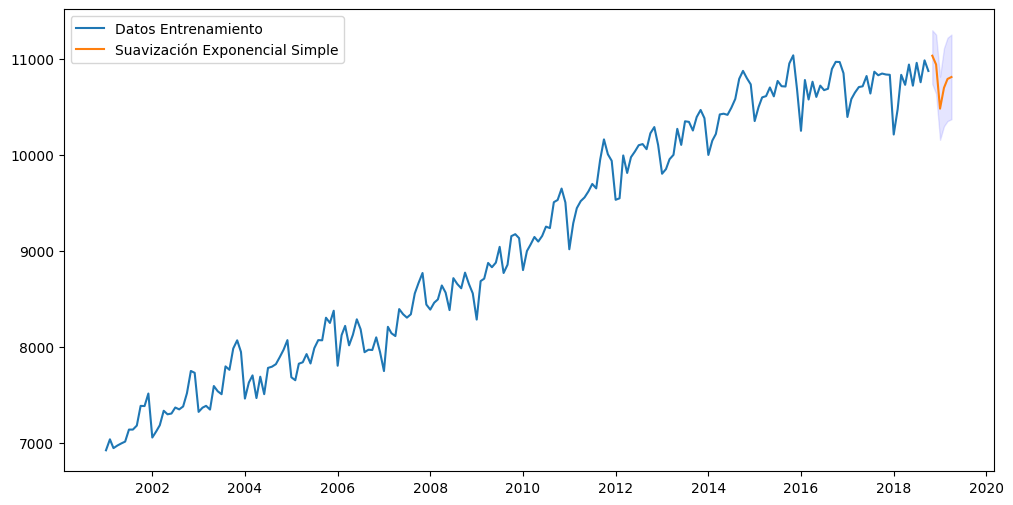

RMSE: 160.51998798520435


In [119]:
suavizacion_exp_lin_holt_winters_mul_mul_mul_mse = build_ets_model(train_td, test_td, horizon, error='mul', trend='mul', seasonal='mul')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10089D+00    |proj g|=  9.88789D-01

At iterate    1    f=  6.77086D+00    |proj g|=  9.99800D-01

At iterate    2    f=  6.55769D+00    |proj g|=  1.21053D-01

At iterate    3    f=  6.53703D+00    |proj g|=  7.91474D-02

At iterate    4    f=  6.53271D+00    |proj g|=  4.79091D-02

At iterate    5    f=  6.53171D+00    |proj g|=  5.56803D-02

At iterate    6    f=  6.52836D+00    |proj g|=  4.97180D-02

At iterate    7    f=  6.52788D+00    |proj g|=  2.53467D-02

At iterate    8    f=  6.52764D+00    |proj g|=  9.22817D-03

At iterate    9    f=  6.52758D+00    |proj g|=  3.97513D-03

At iterate   10    f=  6.52757D+00    |proj g|=  1.28511D-03

At iterate   11    f=  6.52757D+00    |proj g|=  3.78897D-04

At iterate   12    f=  6.52756D+00    |proj g|=  2.44160D-04

At iterate   13    f=  6.5

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



At iterate   39    f=  6.50746D+00    |proj g|=  5.16915D-02

At iterate   40    f=  6.50737D+00    |proj g|=  7.39453D-02

At iterate   41    f=  6.50696D+00    |proj g|=  1.09392D-02

At iterate   42    f=  6.50686D+00    |proj g|=  6.35332D-03

At iterate   43    f=  6.50682D+00    |proj g|=  8.80540D-04

At iterate   44    f=  6.50682D+00    |proj g|=  1.27089D-03

At iterate   45    f=  6.50682D+00    |proj g|=  4.16911D-04

At iterate   46    f=  6.50681D+00    |proj g|=  4.47011D-03

At iterate   47    f=  6.50680D+00    |proj g|=  1.08487D-02

At iterate   48    f=  6.50677D+00    |proj g|=  1.53683D-02

At iterate   49    f=  6.50663D+00    |proj g|=  3.19845D-02

At iterate   50    f=  6.50630D+00    |proj g|=  5.27962D-02

At iterate   51    f=  6.50565D+00    |proj g|=  7.25477D-02

At iterate   52    f=  6.50419D+00    |proj g|=  8.50081D-02

At iterate   53    f=  6.50254D+00    |proj g|=  1.63843D-01

At iterate   54    f=  6.49843D+00    |proj g|=  1.64745D-01

At iter

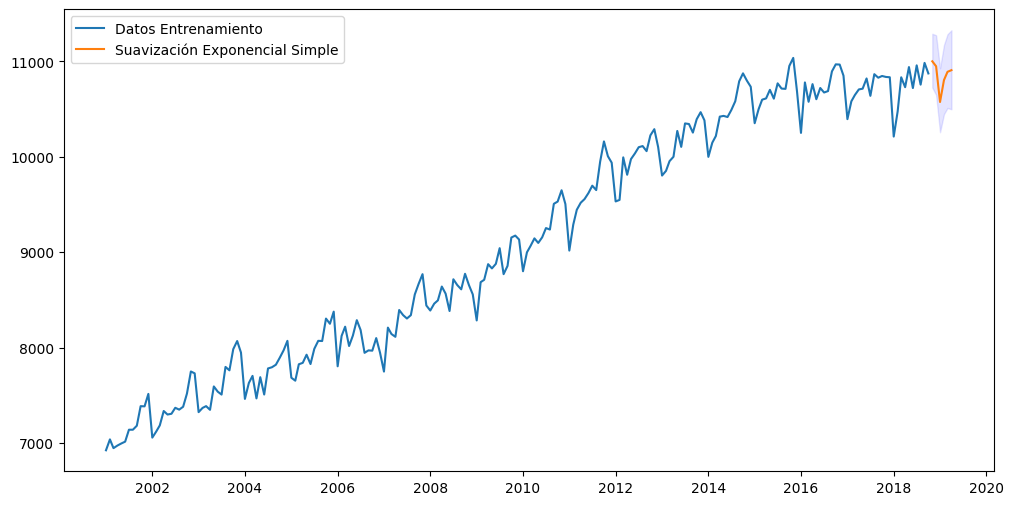

RMSE: 217.14300821829005


In [120]:
suavizacion_exp_lin_holt_winters_mul_add_add_mse = build_ets_model(train_td, test_td, horizon, error='mul', trend='add', seasonal='add')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10266D+00    |proj g|=  3.55438D+00

At iterate    1    f=  7.09853D+00    |proj g|=  3.45576D+00

At iterate    2    f=  7.08726D+00    |proj g|=  1.33622D+00

At iterate    3    f=  7.01203D+00    |proj g|=  1.07066D+01

At iterate    4    f=  6.93246D+00    |proj g|=  1.54615D+01

At iterate    5    f=  6.72586D+00    |proj g|=  6.73371D+00

At iterate    6    f=  6.65849D+00    |proj g|=  7.03995D+00

At iterate    7    f=  6.62650D+00    |proj g|=  4.17906D+00

At iterate    8    f=  6.60085D+00    |proj g|=  6.18945D-01

At iterate    9    f=  6.59090D+00    |proj g|=  6.04835D-01

At iterate   10    f=  6.54842D+00    |proj g|=  6.76723D-01

At iterate   11    f=  6.54613D+00    |proj g|=  1.70135D+00

At iterate   12    f=  6.54406D+00    |proj g|=  3.24858D+00

At iterate   13    f=  6.5

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


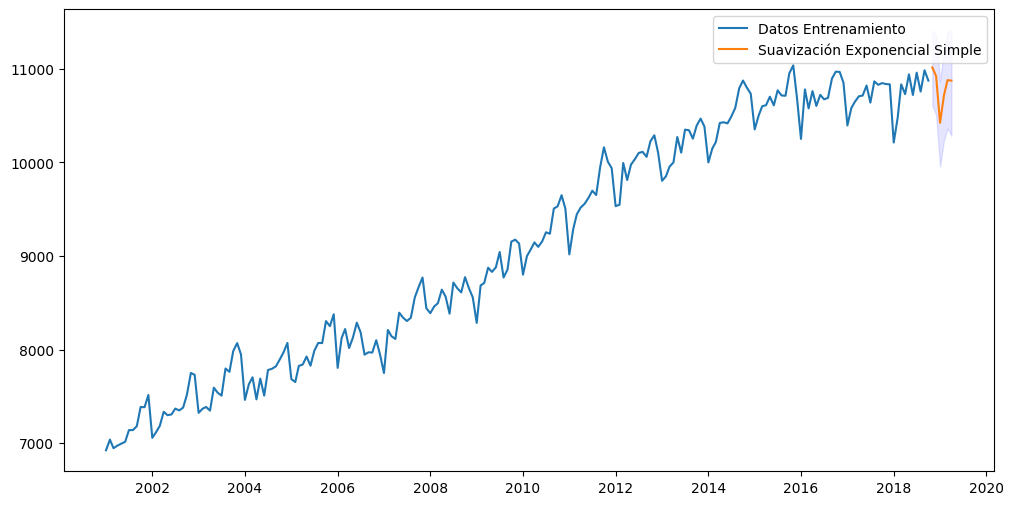

RMSE: 169.1091781930112


In [121]:
suavizacion_exp_lin_holt_winters_mul_mul_add_mse = build_ets_model(train_td, test_td, horizon, error='mul', trend='mul', seasonal='add')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09826D+00    |proj g|=  1.54915D+00

At iterate    1    f=  7.08916D+00    |proj g|=  3.01567D+00

At iterate    2    f=  6.95367D+00    |proj g|=  7.88788D+00

At iterate    3    f=  6.66121D+00    |proj g|=  6.76216D+00

At iterate    4    f=  6.59540D+00    |proj g|=  3.85293D+00

At iterate    5    f=  6.55329D+00    |proj g|=  6.70954D-01

At iterate    6    f=  6.53400D+00    |proj g|=  5.83773D-01

At iterate    7    f=  6.51920D+00    |proj g|=  4.74887D-01

At iterate    8    f=  6.50008D+00    |proj g|=  3.32971D-01

At iterate    9    f=  6.48015D+00    |proj g|=  3.69245D+00

At iterate   10    f=  6.47754D+00    |proj g|=  1.32590D+00

At iterate   11    f=  6.47602D+00    |proj g|=  1.46039D-01

At iterate   12    f=  6.47276D+00    |proj g|=  7.90260D+00
  Positive dir derivative i

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11021.453459  10736.650939  11336.700022
2018-12-01    10923.951992  10613.675574  11237.987880
2019-01-01    10430.846835  10078.755339  10754.134976
2019-02-01    10714.865966  10346.128543  11083.577496
2019-03-01    10869.082923  10509.479645  11262.234886
2019-04-01    10871.564315  10504.597426  11286.199147


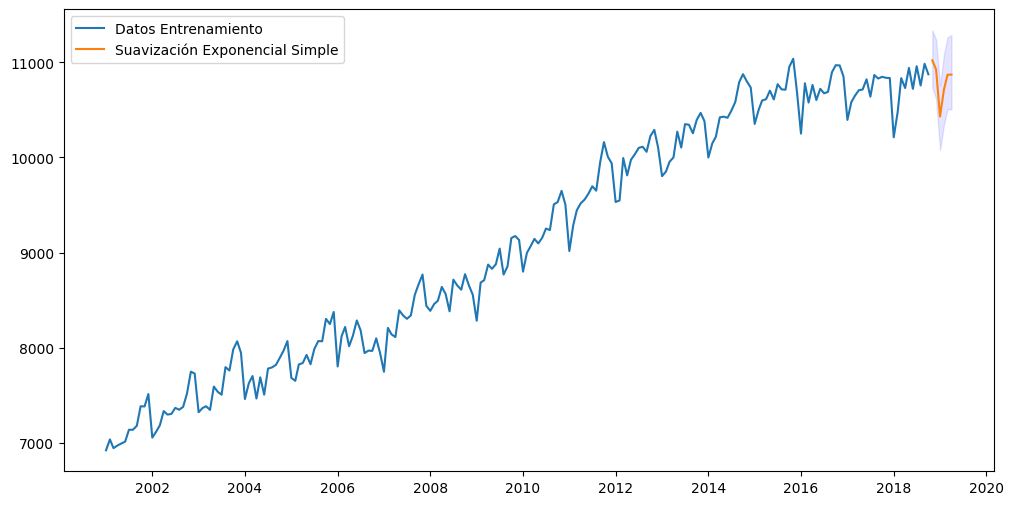

RMSE: 169.2391732872576


In [122]:
suavizacion_exp_lin_holt_winters_add_mul_add_mse = build_ets_model(train_td, test_td, horizon, error='add', trend='mul', seasonal='add')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.17824D+00    |proj g|=  3.18309D+00

At iterate    1    f=  6.67079D+00    |proj g|=  1.54642D+00

At iterate    2    f=  6.45778D+00    |proj g|=  9.24373D-01

At iterate    3    f=  6.35499D+00    |proj g|=  8.71689D-01

At iterate    4    f=  6.32066D+00    |proj g|=  5.61919D-01

At iterate    5    f=  6.28871D+00    |proj g|=  5.43655D-01

At iterate    6    f=  6.26422D+00    |proj g|=  6.88370D-01

At iterate    7    f=  6.24514D+00    |proj g|=  4.19164D-01

At iterate    8    f=  6.23224D+00    |proj g|=  4.85183D-01

At iterate    9    f=  6.21487D+00    |proj g|=  3.00649D-01

At iterate   10    f=  6.21332D+00    |proj g|=  5.29906D-01

At iterate   11    f=  6.20894D+00    |proj g|=  1.65386D-01

At iterate   12    f=  6.20722D+00    |proj g|=  1.68816D-01

At iterate   13    f=  6.2

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


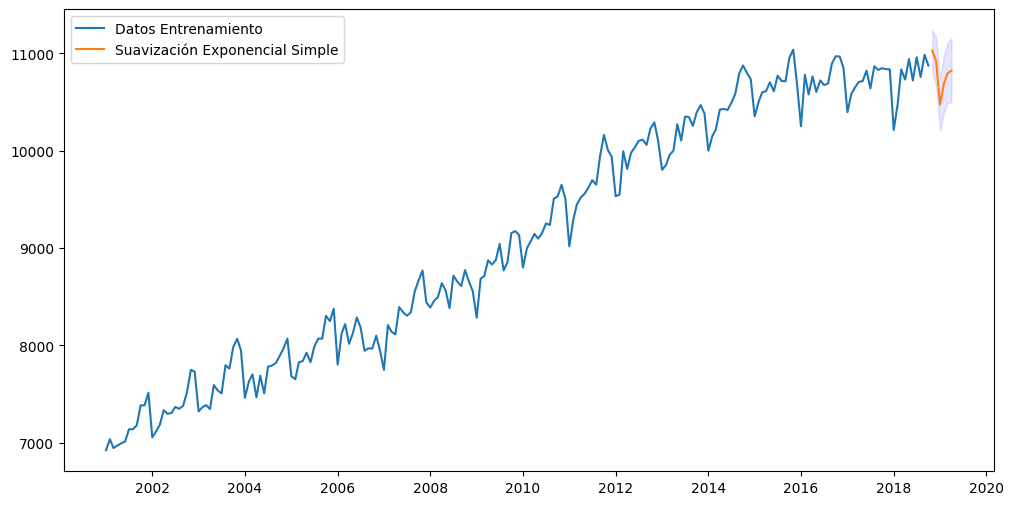

RMSE: 156.41477387046285


In [123]:
suavizacion_exp_lin_holt_winters_add_add_mul_mse = build_ets_model(train_td, test_td, horizon, error='add', trend='add', seasonal='mul')

In [127]:
mse_list = {
	"suavizacion_exp_lin_holt_winters_add_add_mul_mse": suavizacion_exp_lin_holt_winters_add_add_mul_mse,
	"suavizacion_exp_lin_holt_winters_add_mul_add_mse": suavizacion_exp_lin_holt_winters_add_mul_add_mse,
	"suavizacion_exp_lin_holt_winters_mul_mul_add_mse": suavizacion_exp_lin_holt_winters_mul_mul_add_mse,
	"suavizacion_exp_lin_holt_winters_mul_add_add_mse": suavizacion_exp_lin_holt_winters_mul_add_add_mse,
	"suavizacion_exp_lin_holt_winters_mul_mul_mul_mse": suavizacion_exp_lin_holt_winters_mul_mul_mul_mse,
	"suavizacion_exp_lin_holt_winters_add_add_add_mse": suavizacion_exp_lin_holt_winters_add_add_add_mse,
	"suavizacion_exp_lin_holt_mul_add_mse": suavizacion_exp_lin_holt_mul_add_mse,
	"suavizacion_exp_lin_holt_mul_mul_mse": suavizacion_exp_lin_holt_mul_mul_mse,
	"suavizacion_exp_lin_holt_add_mul_mse": suavizacion_exp_lin_holt_add_mul_mse,
	"suavizacion_exp_lin_holt_add_add_mse": suavizacion_exp_lin_holt_add_add_mse,
	"suavizacion_exp_simple_mul_mse": suavizacion_exp_simple_mul_mse,
	"suavizacion_exp_simple_add_mse": suavizacion_exp_simple_add_mse,
}


sorted_mse_list = dict(sorted(mse_list.items(), key=lambda item: item[1]['rmse']))
for key, value in sorted_mse_list.items():
	print(key)
	print("RMSE:", value['rmse'])
	print("Alpha:", value['alpha'])
	print("Beta:", value['beta'])
	print("Gamma:", value['gamma'])
	print("-----------------------")

suavizacion_exp_lin_holt_winters_add_add_mul_mse
RMSE: 156.41477387046285
Alpha: 0.5133659457086996
Beta: 0.0013157803999827881
Gamma: 4.866340542913004e-05
-----------------------
suavizacion_exp_lin_holt_winters_mul_mul_mul_mse
RMSE: 160.51998798520435
Alpha: 0.5465757998344454
Beta: 5.465757998344454e-05
Gamma: 4.5342420016555465e-05
-----------------------
suavizacion_exp_lin_holt_winters_add_add_add_mse
RMSE: 163.6197658382755
Alpha: 0.33972305341386894
Beta: 3.397230534138689e-05
Gamma: 0.3014400779772723
-----------------------
suavizacion_exp_lin_holt_winters_mul_mul_add_mse
RMSE: 169.1091781930112
Alpha: 0.4479776186162167
Beta: 4.4797761861621673e-05
Gamma: 0.3539299785811064
-----------------------
suavizacion_exp_lin_holt_winters_add_mul_add_mse
RMSE: 169.2391732872576
Alpha: 0.3887375729554583
Beta: 3.887375729554583e-05
Gamma: 0.3372493204150533
-----------------------
suavizacion_exp_lin_holt_winters_mul_add_add_mse
RMSE: 217.14300821829005
Alpha: 0.47878169628430745
Bet

In [128]:
suavizacion_exp_lin_holt_winters_add_add_mul_mse['preds']

,Point_forecast,lower_95,upper_95
2018-11-01,11027.470164,10813.445560,11236.457725
2018-12-01,10921.685274,10664.973546,11169.390200
2019-01-01,10472.006017,10204.006281,10740.796728
2019-02-01,10691.000684,10393.381923,10978.265557
2019-03-01,10793.959494,10490.994301,11110.417423
2019-04-01,10821.997331,10497.062993,11153.968074


# Usar Alpha, Beta y Gamma

In [125]:
## Ahora se ajusta el modelo final con todos los datos

final_model = ETSModel(endog=data["Ocupados"],error="add",trend="add",seasonal="mul")
final_model_fit = final_model.fit_constrained({'smoothing_level': 0.5133659457086996,'smoothing_trend': 0.0013157803999827881,'smoothing_seasonal':4.866340542913004e-05})

print("alpha: ", final_model_fit.alpha)
print("beta: ", final_model_fit.beta)
print("gamma: ", final_model_fit.gamma)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.24192D+00    |proj g|=  4.39516D+00

At iterate    1    f=  6.89400D+00    |proj g|=  2.79072D+00

At iterate    2    f=  6.80687D+00    |proj g|=  4.04860D+00

At iterate    3    f=  6.62135D+00    |proj g|=  2.14285D+00

At iterate    4    f=  6.52807D+00    |proj g|=  5.52090D+00

At iterate    5    f=  6.33522D+00    |proj g|=  3.75603D+00

At iterate    6    f=  6.19034D+00    |proj g|=  2.60455D+00

At iterate    7    f=  6.16624D+00    |proj g|=  1.44878D+00

At iterate    8    f=  6.15636D+00    |proj g|=  5.33851D-01

At iterate    9    f=  6.15347D+00    |proj g|=  3.15568D-01

At iterate   10    f=  6.15315D+00    |proj g|=  1.92606D-01

At iterate   11    f=  6.15298D+00    |proj g|=  2.93658D-02

At iterate   12    f=  6.15298D+00    |proj g|=  1.95032D-02

At iterate   13    f=  6.1

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


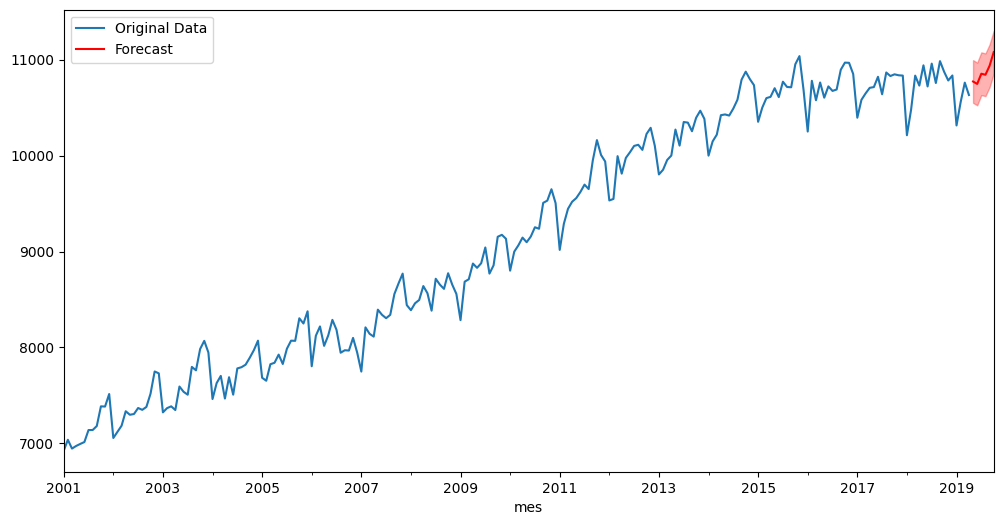

In [126]:

forecast = final_model_fit.forecast(horizon)
fig, ax = plt.subplots(figsize=(12, 6))
data["Ocupados"].plot(ax=ax, label="Original Data")
forecast.plot(ax=ax, label="Forecast", color='red')
plt.fill_between(forecast.index, forecast - 1.96 * final_model_fit.resid.std(), forecast + 1.96 * final_model_fit.resid.std(), color='red', alpha=0.3)
plt.legend()
plt.show()

In [137]:
# Confidence intervals
ci = final_model_fit.get_prediction(start=forecast.index[0], end=forecast.index[-1])
conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean

preds_holt = pd.concat([limits, conf_forecast], axis=1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds_holt

,Point_forecast,lower_95,upper_95
2019-05-01,10772.637895,10558.952610,10993.587732
2019-06-01,10747.213936,10500.502161,11001.106587
2019-07-01,10853.759045,10603.340062,11131.814814
2019-08-01,10842.999842,10545.585851,11159.857484
2019-09-01,10936.731108,10633.351559,11261.642848
2019-10-01,11079.324060,10754.339229,11424.341106
